
... ***CURRENTLY UNDER DEVELOPMENT*** ...


### TODO
- ANNUAL MAXIMA RUNUP: historical vs sim erroneo


In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import pandas as pd
import xarray as xr
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from datetime import datetime


# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.rbf import RBF_Interpolation
from teslakit.mda import Normalize

from teslakit.plotting.extremes import Plot_ReturnPeriodValidation
from teslakit.plotting.estela import Plot_DWTs_Probs
from teslakit.plotting.wts import Plot_Probs_WT_WT


In [2]:
# TODO:


# Seleccionar casos para LisFlood (email ppt Ana)

# puedo ir haciendo los escenarios de cambio climatico que faltan (parte offshore), y cuando termine este nb de hyswash, añadirlo a la parte nearshore (03_). 
# la parte offshore renombrarla de 01_ a 0_2





## Database and Site parameters

In [3]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/albacid/Projects/TeslaKit_projects'
db = Database(p_data)

# set site
db.SetSite('KWAJALEIN_emulator')


# Simulation to plot DWTs and AT
nsim=1


## Load Hyswash simulations

In [40]:
#-------------------------------
# Load historical data

hist_swells = xr.open_dataset('/Users/albacid/Downloads/swells_tcs_historical/swells_HySwash.nc')
hist_TCs = xr.open_dataset('/Users/albacid/Downloads/swells_tcs_historical/tcs_HySwash.nc')

print(hist_swells)
print(hist_TCs)

# TODO: incluir TCs
qru_hist = hist_swells.copy(deep=True)

sys.exit()

for p in hist_swells.profile:
    plt.figure(figsize=(20,5))
    plt.plot(hist_swells.time, hist_swells.Qinv.sel(profile=p), '.' ,label='swell')
    plt.plot(hist_TCs.time, hist_TCs.Qinv.sel(profile=p), '.', label='TCs')
    plt.legend()
    plt.title('profile ' + str(p))

<xarray.Dataset>
Dimensions:  (profile: 36, time: 340362)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 ... 2018-12-16T10:00:00
  * profile  (profile) int64 1 2 3 4 5 6 7 8 9 10 ... 28 29 30 31 32 33 34 35 36
Data variables:
    ru2      (profile, time) float64 ...
    Qinv     (profile, time) float64 ...
<xarray.Dataset>
Dimensions:  (profile: 36, time: 350267)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 ... 2018-12-16T10:00:00
  * profile  (profile) int64 1 2 3 4 5 6 7 8 9 10 ... 28 29 30 31 32 33 34 35 36
Data variables:
    ru2      (profile, time) float64 ...
    Qinv     (profile, time) float64 ...


SystemExit: 

In [4]:
#-------------------------------
# Load simulation data

# Load overtopping & runup q(l/s/m). ru2(m)
qru_0 = xr.open_dataset('/Users/albacid/Projects/SERDP/inputs_Kwajalein/HySwash_outputs/Sims/Sim_0.nc') 
qru_1 = xr.open_dataset('/Users/albacid/Projects/SERDP/inputs_Kwajalein/HySwash_outputs/Sims/Sim_1.nc') 
#qru_2 = xr.open_dataset('/Users/albacid/Projects/SERDP/inputs_Kwajalein/HySwash_outputs/Sims/Sim_2.nc') 
#qru_3 = xr.open_dataset('/Users/albacid/Projects/SERDP/inputs_Kwajalein/HySwash_outputs/Sims/Sim_3.nc') 
#qru_4 = xr.open_dataset('/Users/albacid/Projects/SERDP/inputs_Kwajalein/HySwash_outputs/Sims/Sim_4.nc') 
#qru_5 = xr.open_dataset('/Users/albacid/Projects/SERDP/inputs_Kwajalein/HySwash_outputs/Sims/Sim_5.nc') 
#qru_6 = xr.open_dataset('/Users/albacid/Projects/SERDP/inputs_Kwajalein/HySwash_outputs/Sims/Sim_6.nc') 
#qru_7 = xr.open_dataset('/Users/albacid/Projects/SERDP/inputs_Kwajalein/HySwash_outputs/Sims/Sim_7.nc')
#qru_8 = xr.open_dataset('/Users/albacid/Projects/SERDP/inputs_Kwajalein/HySwash_outputs/Sims/Sim_8.nc')
#qru_9 = xr.open_dataset('/Users/albacid/Projects/SERDP/inputs_Kwajalein/HySwash_outputs/Sims/Sim_9.nc')

print(qru_0)
print()
print(qru_1)


<xarray.Dataset>
Dimensions:  (profile: 36, time: 8765832)
Coordinates:
  * profile  (profile) float64 1.0 2.0 3.0 4.0 5.0 ... 32.0 33.0 34.0 35.0 36.0
  * time     (time) object 2000-01-01 00:00:00 ... 2999-12-31 23:00:00.13
Data variables:
    ru2      (profile, time) float64 ...
    q        (profile, time) float64 ...

<xarray.Dataset>
Dimensions:  (profile: 36, time: 8765832)
Coordinates:
  * profile  (profile) float64 1.0 2.0 3.0 4.0 5.0 ... 32.0 33.0 34.0 35.0 36.0
  * time     (time) object 2000-01-01 00:00:00 ... 2999-12-31 23:00:00.13
Data variables:
    ru2      (profile, time) float64 ...
    q        (profile, time) float64 ...


In [7]:
# Join simulations

qru_0 = qru_0.assign_coords(n_sim=0).expand_dims('n_sim')
qru_1 = qru_1.assign_coords(n_sim=1).expand_dims('n_sim')
#qru_2 = qru_2.assign_coords(n_sim=2).expand_dims('n_sim')
#qru_3 = qru_3.assign_coords(n_sim=3).expand_dims('n_sim')
#qru_4 = qru_4.assign_coords(n_sim=4).expand_dims('n_sim')
#qru_5 = qru_5.assign_coords(n_sim=5).expand_dims('n_sim')
#qru_6 = qru_6.assign_coords(n_sim=6).expand_dims('n_sim')
#qru_7 = qru_7.assign_coords(n_sim=7).expand_dims('n_sim')
#qru_8 = qru_8.assign_coords(n_sim=8).expand_dims('n_sim')
#qru_9 = qru_9.assign_coords(n_sim=9).expand_dims('n_sim')


qru = xr.concat([qru_0, qru_1], dim='n_sim')
#qru = xr.concat([qru_0, qru_1, qru_2, qru_3, qru_4, qru_5, qru_6, qru_7, qru_8, qru_9], dim='n_sim')
print(qru)


<xarray.Dataset>
Dimensions:  (n_sim: 2, profile: 36, time: 8765832)
Coordinates:
  * profile  (profile) float64 1.0 2.0 3.0 4.0 5.0 ... 32.0 33.0 34.0 35.0 36.0
  * time     (time) object 2000-01-01 00:00:00 ... 2999-12-31 23:00:00.13
  * n_sim    (n_sim) int64 0 1
Data variables:
    ru2      (n_sim, profile, time) float64 nan nan nan nan ... nan nan nan nan
    q        (n_sim, profile, time) float64 nan nan nan nan ... nan nan nan nan


In [8]:
# Only for plotting. Load one simulation

offshore_vars = db.Load_SIM_OFFSHORE(n_sim=nsim, vns=['DWT', 'AWT', 'AT'], decode_times=True, use_cftime=True)
print(offshore_vars)
print()


<xarray.Dataset>
Dimensions:  (time: 8765832)
Coordinates:
  * time     (time) object 2000-01-01 00:00:00 ... 2999-12-31 23:00:00.13
Data variables:
    DWT      (time) float32 ...
    AWT      (time) float32 ...
    AT       (time) float32 ...



In [11]:
# para quitar
qru = qru.isel(time=slice(0, 876583))
offshore_vars = offshore_vars.isel(time=slice(0, 876583))

print(qru)
print()
print(offshore_vars)

<xarray.Dataset>
Dimensions:  (n_sim: 2, profile: 36, time: 876583)
Coordinates:
  * profile  (profile) float64 1.0 2.0 3.0 4.0 5.0 ... 32.0 33.0 34.0 35.0 36.0
  * time     (time) object 2000-01-01 00:00:00 ... 2099-12-31 06:00:00
  * n_sim    (n_sim) int64 0 1
Data variables:
    ru2      (n_sim, profile, time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    q        (n_sim, profile, time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

<xarray.Dataset>
Dimensions:  (time: 876583)
Coordinates:
  * time     (time) object 2000-01-01 00:00:00 ... 2099-12-31 06:00:00
Data variables:
    DWT      (time) float32 ...
    AWT      (time) float32 ...
    AT       (time) float32 ...


In [10]:
# Hay nans en los datos:
#for p in qru_2.profile.values:
#    print('profile ' + str(p))
#    
#    kk = qru_2.q.sel(profile=p)
#    print(len(kk.values))
#
#    kk = kk.where(~np.isnan(kk), drop=True)
#    print(len(kk.values))
#    print()
     
    
# sustituir NaNs por 0
qru = qru.where(~np.isnan(qru.q), 0)
print(qru)


<xarray.Dataset>
Dimensions:  (profile: 36, time: 876583)
Coordinates:
  * profile  (profile) float64 1.0 2.0 3.0 4.0 5.0 ... 32.0 33.0 34.0 35.0 36.0
  * time     (time) object 2000-01-01 00:00:00 ... 2099-12-31 06:00:00
    n_sim    int64 1
Data variables:
    ru2      (profile, time) float64 nan nan nan nan nan ... nan nan nan nan nan
    q        (profile, time) float64 nan nan nan nan nan ... nan nan nan nan nan

<xarray.Dataset>
Dimensions:  (profile: 36, time: 876583)
Coordinates:
  * profile  (profile) float64 1.0 2.0 3.0 4.0 5.0 ... 32.0 33.0 34.0 35.0 36.0
  * time     (time) object 2000-01-01 00:00:00 ... 2099-12-31 06:00:00
    n_sim    int64 1
Data variables:
    ru2      (profile, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    q        (profile, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0


In [12]:
# DatetimeGregorian to datetime
time = [x.timetuple() for x in qru.time.values];
time = [datetime(*x[:6]) for x in time];

qru['time'] = time
offshore_vars['time'] = time


# round times to hour
qru['time'] = qru['time'].dt.round('H')
offshore_vars['time'] = offshore_vars['time'].dt.round('H')


## Extreme events: Annual Maxima overtoppings

In [41]:
#--------------------------
# Simulations

# Neglect values in each profile where Q<0.01 l/s (neglegible)
qru['q'] = qru.q.where(qru.q.values>=0.01, 0)

# Sum all profiles
qru_all = qru.sum(dim='profile')

print(qru)
print()
print(qru_all)
print()


#--------------------------
# Historical data

# Neglect values in each profile where Q<0.01 l/s (neglegible)
qru_hist['Qinv'] = qru_hist.Qinv.where(qru_hist.Qinv.values>=0.01, 0)

# Sum all profiles
qru_hist_all = qru_hist.sum(dim='profile')
print(qru_hist)
print()
print(qru_hist_all)

<xarray.Dataset>
Dimensions:  (n_sim: 2, profile: 36, time: 876583)
Coordinates:
  * profile  (profile) float64 1.0 2.0 3.0 4.0 5.0 ... 32.0 33.0 34.0 35.0 36.0
  * time     (time) datetime64[ns] 2000-01-01 ... 2099-12-31T06:00:00
  * n_sim    (n_sim) int64 0 1
Data variables:
    ru2      (n_sim, profile, time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    q        (n_sim, profile, time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

<xarray.Dataset>
Dimensions:  (n_sim: 2, time: 876583)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 ... 2099-12-31T06:00:00
  * n_sim    (n_sim) int64 0 1
Data variables:
    ru2      (n_sim, time) float64 17.3 17.95 17.61 16.38 ... 16.72 20.64 23.21
    q        (n_sim, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

<xarray.Dataset>
Dimensions:  (profile: 36, time: 340362)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 ... 2018-12-16T10:00:00
  * profile  (profile) int64 1 2 3 4 5 6 7 8 9 10 ... 28 29 30 31 32 33 34 

In [48]:
# Obtain annual maxima events

def peaks_cleaner(xda):
    '''
    Locates annual maxima and attached variable peak, cleans everything else
    
    xda - input data array
    '''
    
    # find annual maxima and dates   
    def grouped_max(da, dim=None):
        return da.isel(**{dim: da.argmax(dim)})
    xmax = xda.groupby('time.year').apply(grouped_max, dim='time')
    
    # initialize output (clean data array)
    xda_clean = xda.copy(deep=True)
    xda_clean.values[:] = np.nan
    
    # find all ZERO values (peaks must start and end at val=0)
    ix_zs = np.where(xda.values[:] == 0)[0]

    # clean data year by year
    for t_peak, v_peak in zip(xmax.time.values[:], xmax.values[:]):
        
        # skip years without value
        if v_peak == 0: continue
        
        # find peak max index, locate this index "zero indexes" left and right neighbours
        ix_p = np.where(t_peak == xda.time)[0]
        
        ix_z0 = ix_zs[np.where(ix_zs<ix_p)[0][-1]] +1 # first zero to the left
        ix_z1 = ix_zs[np.where(ix_zs>ix_p)[0][0]]  # first zero to the right
        
        # fill clean output with main peak values
        xda_clean.values[ix_z0:ix_z1] = xda.values[ix_z0:ix_z1]
        
        # TODO: usa/modifica estos prints para asegurarte que hace lo que quieres
        #print()
        #print(t_peak, v_peak)
        #print(ix_p)
        #print(ix_z0, ix_z1)
        #print(xda.values[ix_z0:ix_z1])
        #print(xda_clean.values[ix_z0:ix_z1])
    
    return xda_clean

<xarray.Dataset>
Dimensions:  (time: 876583)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 ... 2099-12-31T06:00:00
    n_sim    int64 0
Data variables:
    ru2      (time) float64 17.3 17.95 17.61 16.38 ... 12.43 16.72 20.64 23.21
    q        (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0

<xarray.DataArray 'q' (time: 876583)>
array([nan, nan, nan, ..., nan, nan, nan])
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 ... 2099-12-31T06:00:00
    n_sim    int64 0
<xarray.Dataset>
Dimensions:  (time: 876583)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 ... 2099-12-31T06:00:00
    n_sim    int64 1
Data variables:
    ru2      (time) float64 17.3 17.95 17.61 16.38 ... 12.43 16.72 20.64 23.21
    q        (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0

<xarray.DataArray 'q' (time: 876583)>
array([nan, nan, nan, ..., nan, nan, nan])
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 ... 2099-12-31T06:00:00
 

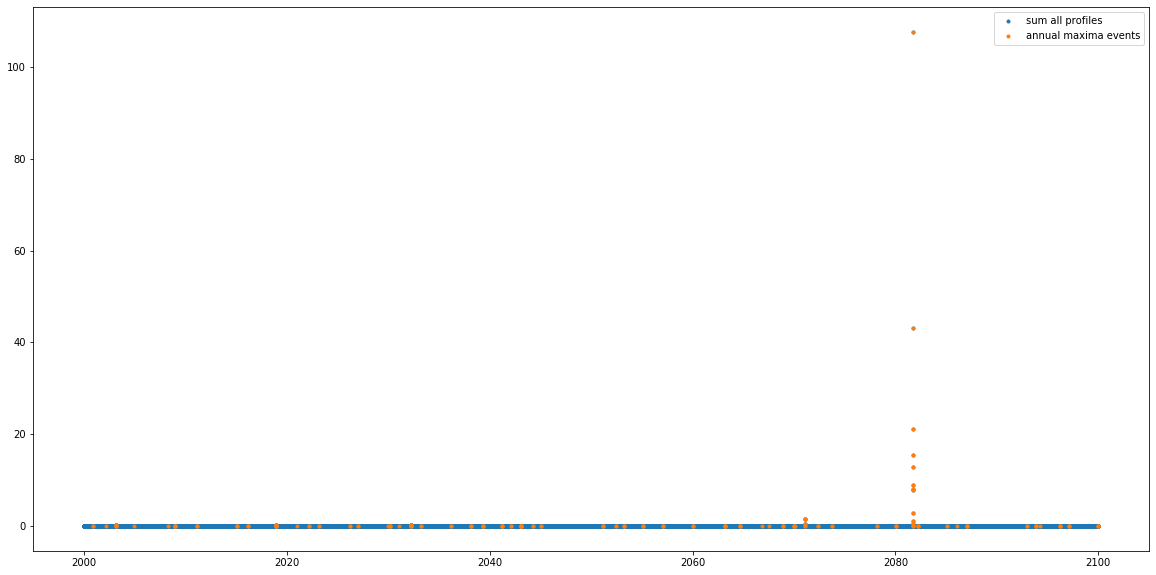

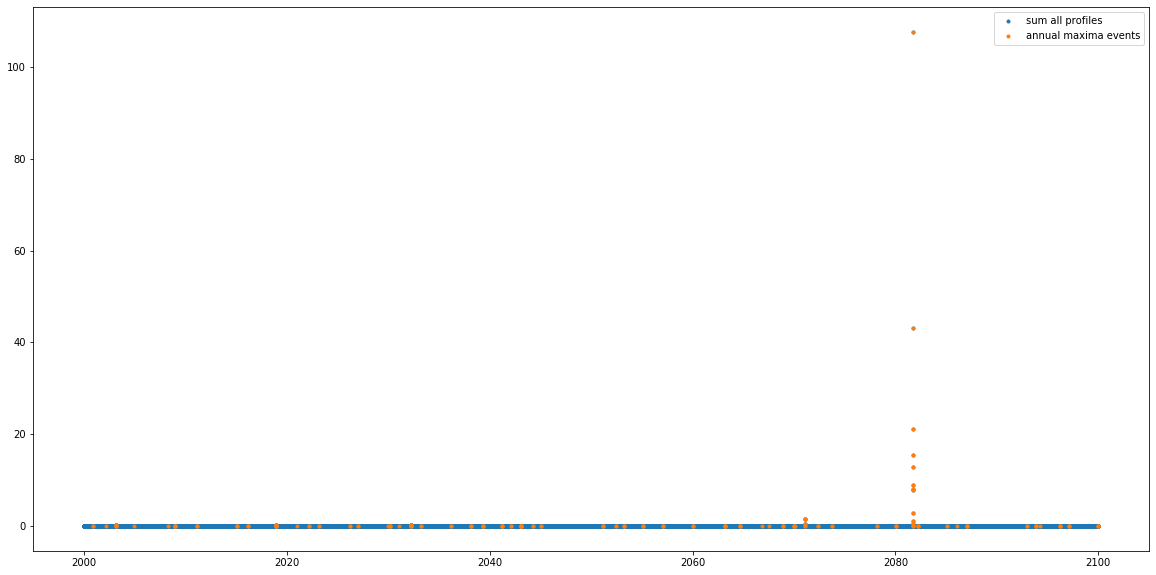

In [62]:
# Obtain Annual maxima events for each n_sim

for n in qru_all.n_sim:
    
    qru_all_nsim = qru_all.isel(n_sim=n)    
    print(qru_all_nsim)
    print()
    
    qru_all_nsim_Amax = peaks_cleaner(qru_all_nsim.q)
    print(qru_all_nsim_Amax)
    
    plt.figure(figsize=(20,10))
    plt.plot(qru_all_nsim.time, qru_all_nsim.q, '.', label='sum all profiles')
    plt.plot(qru_all_nsim_Amax.time, qru_all_nsim_Amax.values, '.', label= 'annual maxima events')
    plt.legend()
    
# TODO: save all sims

In [ ]:
# Save annual maxima events for each profile for LisFlood

#### Overtopping to inundation volumes

In [15]:
# Obtain duration of events
qru_all['duration'] = qru_all.q*np.nan
qru_all['ind_ini'] = qru_all.q*np.nan
qru_all['ind_end'] = qru_all.q*np.nan

for n in qru_all.n_sim:
    
    ind = np.where(qru_all.q.sel(n_sim=n)!=0)[0]

    ind2 = np.where(np.diff(ind)!=1)[0]
    ind2 = np.concatenate(([-1],ind2)) # fix last event?
    
    ind3 = np.diff(ind2)

    # new var for qru_all
    ed = np.zeros(len(qru_all.time))*np.nan
    ed_ini = np.zeros(len(qru_all.time))*np.nan
    ed_end = np.zeros(len(qru_all.time))*np.nan

    for ix in range(len(ind2)-1):        
        ix1 = ind2[ix]+1
        ix2 = ind2[ix+1]+1

        ind_t = ind[ix1:ix2]
        ed[ind_t] = ind3[ix]
        ed_ini[ind_t] = ind_t[0]
        ed_end[ind_t] = ind_t[-1]

    qru_all['duration'][n,:] = ed # duration of the overtopping event (hours)
    qru_all['ind_ini'][n,:] = ed_ini # duration of the overtopping event (hours)
    qru_all['ind_end'][n,:] = ed_end # duration of the overtopping event (hours)
    
print(qru_all)


<xarray.Dataset>
Dimensions:   (n_sim: 2, time: 876583)
Coordinates:
  * time      (time) datetime64[ns] 2000-01-01 ... 2099-12-31T06:00:00
  * n_sim     (n_sim) int64 0 1
Data variables:
    ru2       (n_sim, time) float64 17.3 17.95 17.61 16.38 ... 16.72 20.64 23.21
    q         (n_sim, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    duration  (n_sim, time) float64 nan nan nan nan nan ... nan nan nan nan nan
    ind_ini   (n_sim, time) float64 nan nan nan nan nan ... nan nan nan nan nan
    ind_end   (n_sim, time) float64 nan nan nan nan nan ... nan nan nan nan nan


In [17]:
# Obtain instant of annual maxima overtopping from the sum of all profiles
qru_all_AMax = qru_all.groupby('time.year').apply(grouped_max, vn='q', dim='time')
print(qru_all_AMax)
print()

# Remove values where annual maxima overtopping is 0:
qru_all_AMax = qru_all_AMax.where(qru_all_AMax.q!=0, drop=True)
print(qru_all_AMax)
print()

# Obtain inundation volumes from overtopping (maximo caudal * duracion): Estamos sobreestimando??
qru_all_AMax['volume'] = qru_all_AMax.q * qru_all_AMax.duration*3600 # volume in l/m
print(qru_all_AMax)
print()

# Remove values where duration is nan???:
qru_all_AMax = qru_all_AMax.where(~np.isnan(qru_all_AMax.volume), drop=True)
print(qru_all_AMax)
print()


# Select instant of annual maxima for each profile.......FIX!!!!!!!!!!!!!
#qru_AMax = qru.sel(time = qru_all_AMax.time)
#print(qru_AMax)
#print()
#qru_AMax = qru.isel(time = qru_all_AMax.time)
#print(qru_AMax)
#print()



<xarray.Dataset>
Dimensions:   (n_sim: 2, year: 100)
Coordinates:
  * n_sim     (n_sim) int64 0 1
    time      (year, n_sim) datetime64[ns] 2000-12-12T06:00:00 ... 2099-12-15T06:00:00
  * year      (year) int64 2000 2001 2002 2003 2004 ... 2095 2096 2097 2098 2099
Data variables:
    ru2       (year, n_sim) float64 23.4 23.4 4.141 4.141 ... 8.208 33.73 33.73
    q         (year, n_sim) float64 0.03542 0.03542 0.0 ... 0.0 0.01497 0.01497
    duration  (year, n_sim) float64 2.0 2.0 nan nan 1.0 ... 3.0 nan nan nan nan
    ind_ini   (year, n_sim) float64 8.309e+03 8.309e+03 nan nan ... nan nan nan
    ind_end   (year, n_sim) float64 8.31e+03 8.31e+03 nan nan ... nan nan nan

<xarray.Dataset>
Dimensions:   (n_sim: 2, year: 57)
Coordinates:
  * n_sim     (n_sim) int64 0 1
    time      (year, n_sim) datetime64[ns] 2000-12-12T06:00:00 ... 2099-12-15T06:00:00
  * year      (year) int64 2000 2002 2003 2004 2008 ... 2093 2094 2096 2097 2099
Data variables:
    ru2       (year, n_sim) float64 23

SystemExit: 

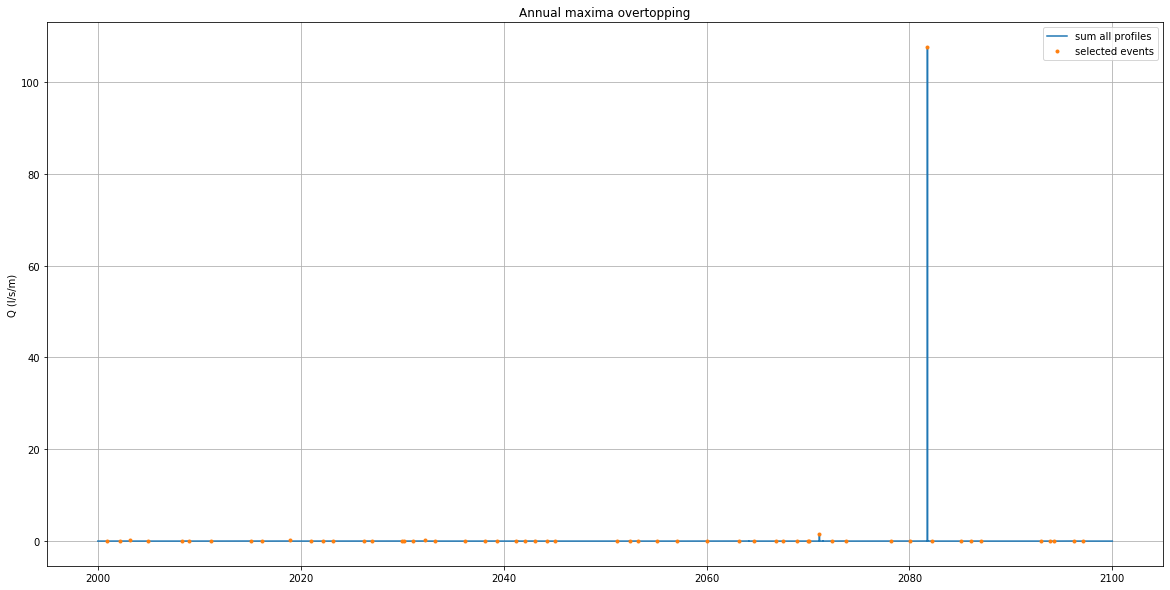

In [20]:
# plot annual maxima overtopping for one simulation

plt.figure(figsize=(20,10))
plt.plot(qru_all.time, qru_all.q.sel(n_sim=nsim), label='sum all profiles')
plt.plot(qru_all_AMax.time.sel(n_sim=nsim), qru_all_AMax.q.sel(n_sim=nsim), '.',label='selected events')
plt.legend()
plt.grid()
plt.ylabel('Q (l/s/m)')
plt.title('Annual maxima overtopping')
#plt.yscale('log')
#plt.xlim(datetime(2099,7,1), datetime(2099,8,1))
sys.exit()


for p in qru.profile.values:        
    plt.figure(figsize=(20,5))
    plt.plot(qru.time, qru.q.sel(n_sim=nsim, profile=p), label=('profile ' + str(p) ))
    plt.plot(qru_AMax.time.sel(n_sim=nsim), qru_AMax.q.sel(n_sim=nsim, profile=p), '.', label='selected events')    
    plt.legend()
    plt.grid()
    #plt.xlim(datetime(2099,7,1), datetime(2099,8,1))

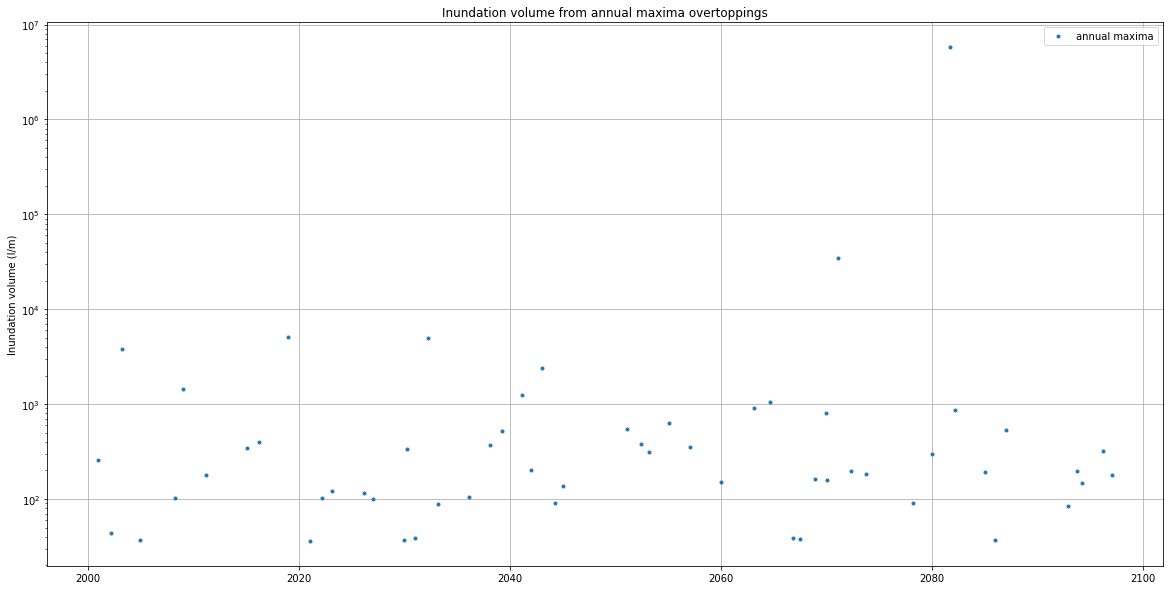

In [22]:
# plot annual maxima inundation volume for one simulation

plt.figure(figsize=(20,10))
plt.plot(qru_all_AMax.time.sel(n_sim=nsim), qru_all_AMax.volume.sel(n_sim=nsim), '.',label='annual maxima')
plt.legend()
plt.grid()
plt.title('Inundation volume from annual maxima overtoppings')
plt.ylabel('Inundation volume (l/m)')
plt.yscale('log')


## DWT and AT associated to Annual maxima events

In [23]:
offshore_vars['AT_category'] = offshore_vars.AT*np.nan
print(offshore_vars)
print()

# Tide values <= 0 assign to cat 1
ind = np.where(offshore_vars.AT <=0)[0]
offshore_vars['AT_category'][ind] = 1


# Tide values >0 assign to cat 2-6
AT_positive = offshore_vars.AT.where(offshore_vars.AT>0, drop=True)
AT_perc = np.percentile(AT_positive.values, [50, 75, 95, 99, 100])

# cat 1
ind = np.where((offshore_vars.AT > 0) & (offshore_vars.AT <= AT_perc[0]))[0]
offshore_vars['AT_category'][ind] = 2

# cat 2
ind = np.where((offshore_vars.AT > AT_perc[0]) & (offshore_vars.AT <= AT_perc[1]))[0]
offshore_vars['AT_category'][ind] = 3

# cat 3
ind = np.where((offshore_vars.AT > AT_perc[1]) & (offshore_vars.AT <= AT_perc[2]))[0]
offshore_vars['AT_category'][ind] = 4

# cat 4
ind = np.where((offshore_vars.AT > AT_perc[2]) & (offshore_vars.AT <= AT_perc[3]))[0]
offshore_vars['AT_category'][ind] = 5

# cat 5
ind = np.where((offshore_vars.AT > AT_perc[3]) & (offshore_vars.AT <= AT_perc[4]))[0]
offshore_vars['AT_category'][ind] = 6


print('AT cat 1:', '<0')
print('AT cat 2:', 0, '-', round(AT_perc[0],4))
print('AT cat 3:', round(AT_perc[0],4), '-',  round(AT_perc[1],4))
print('AT cat 4:', round(AT_perc[1],4), '-',  round(AT_perc[2],4))
print('AT cat 5:', round(AT_perc[2],4), '-',  round(AT_perc[3],4))
print('AT cat 6:', round(AT_perc[3],4), '-',  round(AT_perc[4],4))


<xarray.Dataset>
Dimensions:      (time: 876583)
Coordinates:
  * time         (time) datetime64[ns] 2000-01-01 ... 2099-12-31T06:00:00
Data variables:
    DWT          (time) float32 ...
    AWT          (time) float32 ...
    AT           (time) float32 ...
    AT_category  (time) float32 nan nan nan nan nan nan ... nan nan nan nan nan

AT cat 1: <0
AT cat 2: 0 - 0.3039
AT cat 3: 0.3039 - 0.4972
AT cat 4: 0.4972 - 0.77
AT cat 5: 0.77 - 0.9031
AT cat 6: 0.9031 - 1.068


In [24]:
# Select variables at annual maxima. Choose one simulation
offshore_vars_AMax = offshore_vars.sel(time=qru_all_AMax.time.sel(n_sim=nsim))

print(offshore_vars_AMax)

u, indices = np.unique(offshore_vars_AMax.AT_category, return_counts=True)
print()
print(u)
print(indices)


<xarray.Dataset>
Dimensions:      (year: 56)
Coordinates:
    time         (year) datetime64[ns] 2000-12-12T06:00:00 ... 2097-02-17T20:00:00
    n_sim        int64 1
  * year         (year) int64 2000 2002 2003 2004 2008 ... 2093 2094 2096 2097
Data variables:
    DWT          (year) float32 ...
    AWT          (year) float32 ...
    AT           (year) float32 ...
    AT_category  (year) float32 5.0 6.0 6.0 5.0 1.0 4.0 ... 4.0 2.0 3.0 6.0 4.0

[1. 2. 3. 4. 5. 6.]
[ 3  1  4 14 16 18]


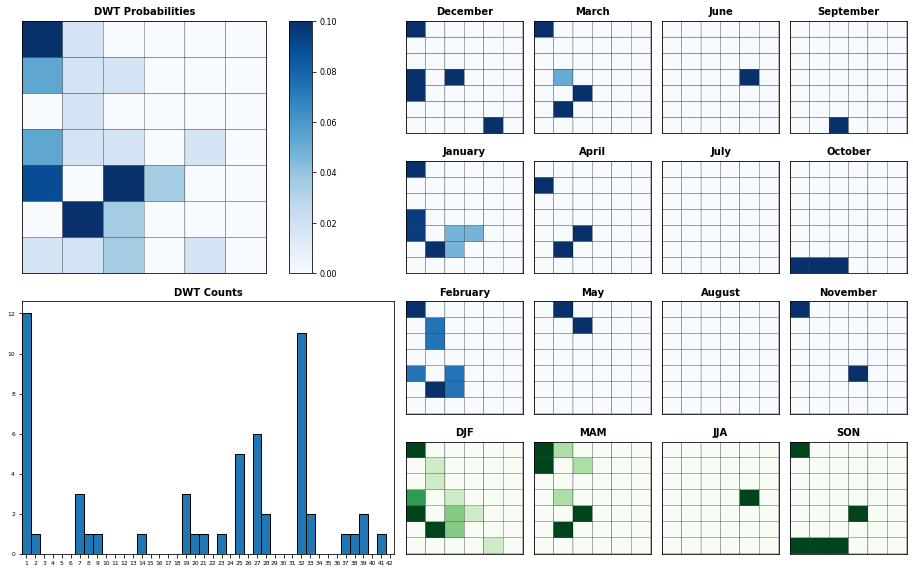

In [25]:
# Plot Annual Maxima DWT probabilities by month
n_clusters_DWT = 42   # number of DWT clusters

Plot_DWTs_Probs(offshore_vars_AMax['DWT'].values, offshore_vars_AMax.time.values, n_clusters_DWT);

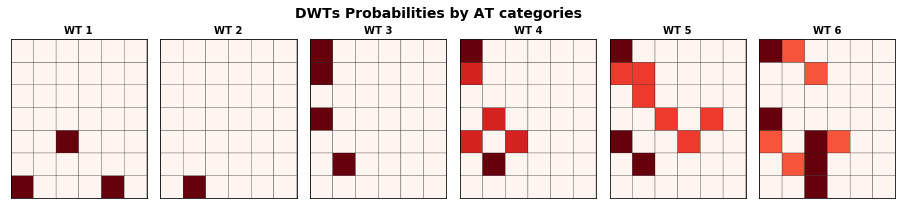

In [26]:
# Plot Annual Maxima DWT probabilities by AT category (1-6)

n_clusters_AT = 6
AT_amp = 42

AT_amp = offshore_vars_AMax['AT_category'].values-1
DWT_bmus = offshore_vars_AMax['DWT'].values-1

Plot_Probs_WT_WT(
    AT_amp, DWT_bmus, n_clusters_AT, n_clusters_DWT,
    wt_colors=False, ttl='DWTs Probabilities by AT categories');




## Return periods from Annual Maxima

<xarray.Dataset>
Dimensions:  (year: 40)
Coordinates:
    time     (year) datetime64[ns] 1979-01-03T09:00:00 ... 2018-01-01
  * year     (year) int64 1979 1980 1981 1982 1983 ... 2014 2015 2016 2017 2018
Data variables:
    ru2      (year) float64 22.94 27.47 24.88 15.4 ... 21.85 19.92 0.1828 5.059
    Qinv     (year) float64 21.71 0.2226 1.877 0.08982 ... 0.0631 0.0 0.0

<xarray.Dataset>
Dimensions:  (year: 36)
Coordinates:
    time     (year) datetime64[ns] 1979-01-03T09:00:00 ... 2016-03-11T06:00:00
  * year     (year) int64 1979 1980 1981 1982 1983 ... 2012 2013 2014 2015 2016
Data variables:
    ru2      (year) float64 22.94 27.47 24.88 15.4 ... 23.46 18.39 21.85 19.92
    Qinv     (year) float64 21.71 0.2226 1.877 ... 0.05327 0.07346 0.0631


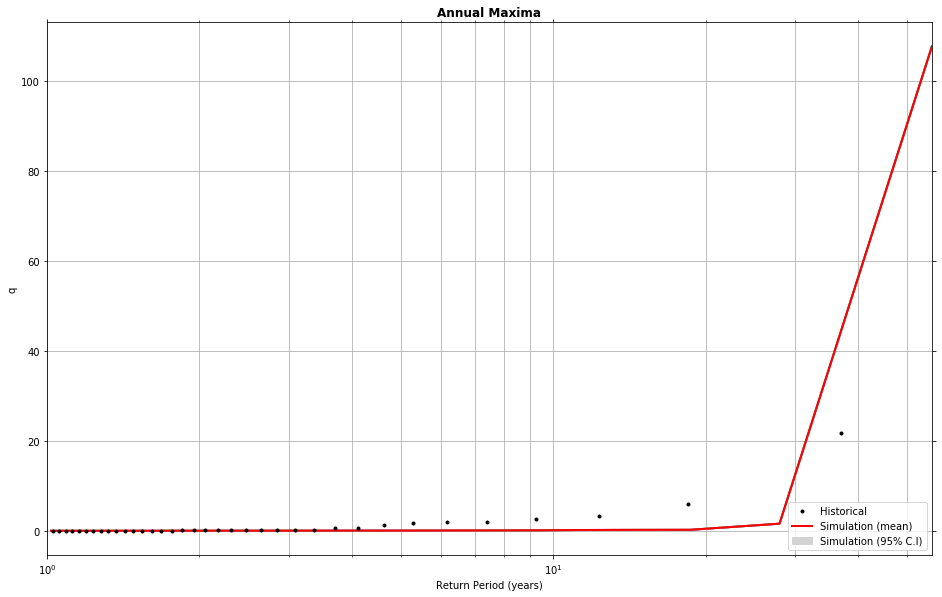

In [42]:
# Obtain instant of annual maxima overtopping from the sum of all profiles
qru_hist_all_AMax = qru_hist_all.groupby('time.year').apply(grouped_max, vn='Qinv', dim='time')
print(qru_hist_all_AMax)
print()

# Remove values where annual maxima overtopping is 0:
qru_hist_all_AMax = qru_hist_all_AMax.where(qru_hist_all_AMax.Qinv!=0, drop=True)
print(qru_hist_all_AMax)

Plot_ReturnPeriodValidation(qru_hist_all_AMax['Qinv'], qru_all_AMax['q'].transpose());
#Plot_ReturnPeriodValidation(qru_all_AMax['volume'].sel(n_sim=nsim), qru_all_AMax['volume'].transpose());

# remove nans ???



In [91]:
SIM_C_h = db.Load_SIM_OFFSHORE_all(decode_times=True, use_cftime=True)
print(SIM_C_h)


<xarray.Dataset>
Dimensions:     (n_sim: 10, time: 8765832)
Coordinates:
  * time        (time) object 2000-01-01 00:00:00 ... 2999-12-31 23:00:00.13
  * n_sim       (n_sim) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    SS          (time, n_sim) float64 ...
    MJO         (time, n_sim) float64 ...
    level       (time, n_sim) float64 ...
    wind_dir    (time, n_sim) float64 ...
    TWL         (time, n_sim) float64 ...
    AWT         (time, n_sim) float64 ...
    AWL         (time, n_sim) float64 ...
    max_storms  (time, n_sim) float64 ...
    MMSL        (time, n_sim) float64 ...
    Dir         (time, n_sim) float64 ...
    DWT         (time, n_sim) float64 ...
    wind_speed  (time, n_sim) float64 ...
    AT          (time, n_sim) float64 ...
    Tp          (time, n_sim) float64 ...
    mslp        (time, n_sim) float64 ...
    Hs          (time, n_sim) float64 ...


In [92]:

sim_AMax = SIM_C_h.groupby('time.year').apply(grouped_max, vn='AWL', dim='time')
print(sim_AMax['AWL'].transpose())


<xarray.DataArray 'AWL' (n_sim: 10, year: 1000)>
array([[1.28859305, 0.87215275, 1.06284773, ..., 0.92875326, 1.11366844,
        0.84255898],
       [1.13242078, 0.96351206, 0.94780171, ..., 0.83334625, 1.26102328,
        1.40075493],
       [0.95421553, 0.94239271, 0.91209894, ..., 1.27749252, 0.93405277,
        1.03592777],
       ...,
       [0.95908374, 0.93894541, 1.05140936, ..., 1.26629782, 0.98569471,
        1.04656291],
       [0.93151611, 0.91570938, 0.8885926 , ..., 0.97120196, 0.92048782,
        0.94822937],
       [0.98555404, 1.12972367, 1.04381168, ..., 1.05403626, 1.05189705,
        0.97443587]])
Coordinates:
  * n_sim    (n_sim) int64 0 1 2 3 4 5 6 7 8 9
    time     (year, n_sim) object 2000-05-25 13:00:00 ... 2999-02-21 00:00:00
  * year     (year) int64 2000 2001 2002 2003 2004 ... 2995 2996 2997 2998 2999


In [86]:

# Historical
HIST_C_h = db.Load_HIST_OFFSHORE(decode_times=True)
print(HIST_C_h)

# remove nans before and after AWL
ix_nonan = np.squeeze(np.argwhere(~np.isnan(HIST_C_h['AWL'].values[:])))
HIST_C_nonan = HIST_C_h.isel(time = ix_nonan)

# calculate AWL annual maxima dataset
hist_AMax = HIST_C_nonan.groupby('time.year').apply(grouped_max, vn='AWL', dim='time')
print(hist_AMax)


<xarray.Dataset>
Dimensions:      (time: 1228921)
Coordinates:
  * time         (time) datetime64[ns] 1880-06-01 ... 2020-08-11
Data variables:
    swell_2_Tp   (time) float64 ...
    MJO          (time) float64 ...
    level        (time) float64 ...
    TWL          (time) float64 ...
    AWT          (time) float64 ...
    swell_2_Hs   (time) float64 ...
    AWL          (time) float64 ...
    swell_1_Tp   (time) float64 ...
    max_storms   (time) bool ...
    MMSL         (time) float64 ...
    swell_2_Dir  (time) float64 ...
    swell_1_Hs   (time) float64 ...
    sea_Dir      (time) float64 ...
    Dir          (time) float64 ...
    DWT          (time) float64 ...
    AT           (time) float64 ...
    Tp           (time) float64 ...
    sea_Tp       (time) float64 ...
    swell_1_Dir  (time) float64 ...
    sea_Hs       (time) float32 ...
    Hs           (time) float64 ...
<xarray.Dataset>
Dimensions:      (year: 42)
Coordinates:
    time         (year) datetime64[ns] 1979-0

In [88]:
print(hist_AMax['AWL'])
print()
print(qru_all_AMax['volume'])

<xarray.DataArray 'AWL' (year: 42)>
array([1.07703956, 0.95440366, 1.19361884, 0.97947271, 0.88673231,
       0.96725154, 0.89751186, 0.874581  , 0.90518908, 1.15490214,
       1.27104963, 1.05366095, 0.89412949, 1.09957293, 1.06882852,
       0.91218232, 0.97114539, 1.06204113, 1.02713025, 0.89666282,
       0.81477102, 0.92788856, 1.27139535, 0.92759179, 0.79700215,
       0.82553226, 0.8384193 , 0.7773031 , 0.91826607, 1.00935323,
       0.97957335, 0.84814522, 0.9794702 , 0.79252409, 0.7864621 ,
       0.84245266, 0.85066379, 1.02690672, 0.83529892, 0.94355758,
       1.12357295, 1.1340999 ])
Coordinates:
    time     (year) datetime64[ns] 1979-01-03T08:00:00 ... 2020-01-01
  * year     (year) int64 1979 1980 1981 1982 1983 ... 2016 2017 2018 2019 2020

<xarray.DataArray 'volume' (year: 100)>
array([           nan, 7.96620938e+02, 8.35208370e+01, 3.51801167e+02,
       1.13549236e+03, 2.49953397e+03, 1.02603364e+02, 3.88629726e+02,
                  nan,            nan, 7.42725423e